In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py

In [4]:
f = h5py.File('../data/icSHAPE/Spitale_2015_invivo/CDS', 'r')
icshape = f['feature/icshape'][:]
name = f['name'][:]
start = f['start'][:]
end = f['end'][:]
f.close()

In [7]:
import scipy.signal
import scipy.stats

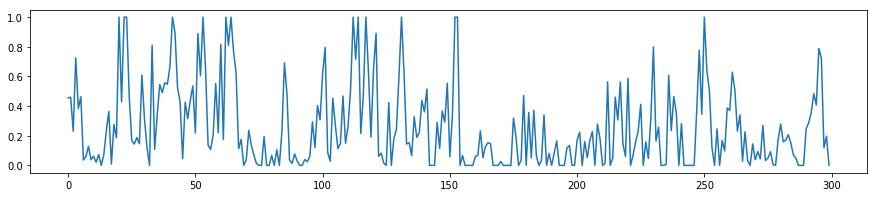

In [54]:
values = np.copy(icshape[400:700])
values[np.isnan(values)] = -0.1
subplots(figsize=(15, 3))
plot(values)

In [89]:
def plot_signal_smooth(x):
    x = np.copy(x)
    x[np.isnan(x)] = -0.1
    window = scipy.signal.gaussian(20, 1)
    #window = scipy.signal.boxcar(3)/3
    subplots(figsize=(15, 3))
    plot(np.arange(x.shape[0]), scipy.signal.convolve(x, window, mode='same')/window.sum())
    xlabel('Position')
    ylabel('icSHAPE values')
    
def plot_signal(x):
    x = np.copy(x)
    x[np.isnan(x)] = -0.1
    subplots(figsize=(15, 3))
    plot(np.arange(x.shape[0]), x)
    xlabel('Position')
    ylabel('icSHAPE values')

In [79]:
scipy.signal.gaussian(20, 1.5).sum()

3.7599424119003602

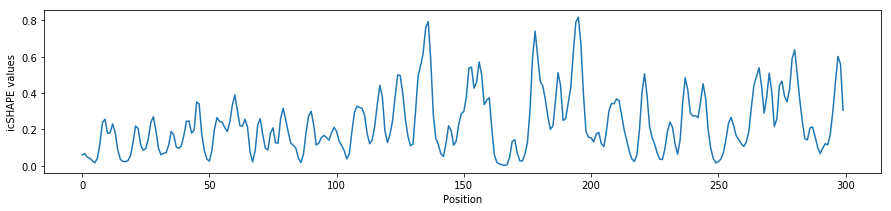

In [90]:
plot_signal_smooth(icshape[0:300])

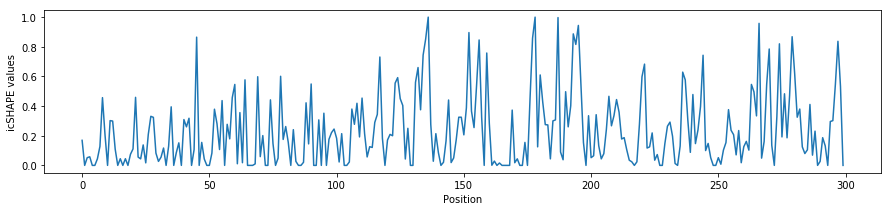

In [91]:
plot_signal(icshape[0:300])

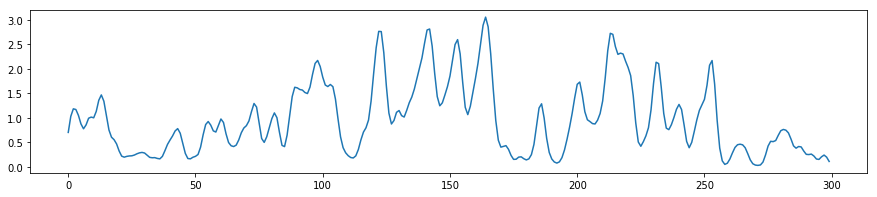

In [9]:
plot_signal_smooth(icshape[300:600])

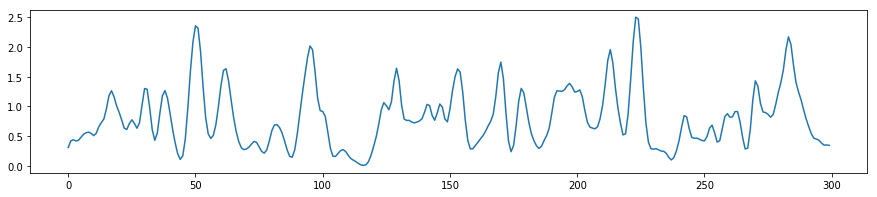

In [10]:
plot_signal_smooth(icshape[600:900])

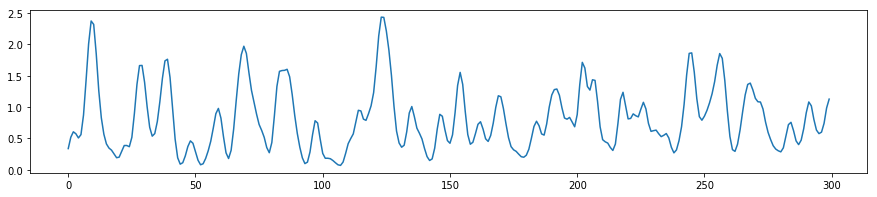

In [11]:
plot_signal_smooth(icshape[900:1200])

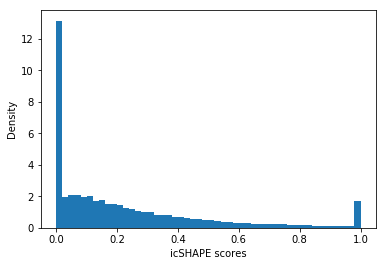

In [94]:
icshape_nonzero = icshape[np.logical_not(np.isnan(icshape))]
#icshape_nonzero = icshape_nonzero[np.nonzero(icshape_nonzero)[0]]
hist(icshape_nonzero, bins=50, normed=True)
xlabel('icSHAPE scores')
ylabel('Density')
pass

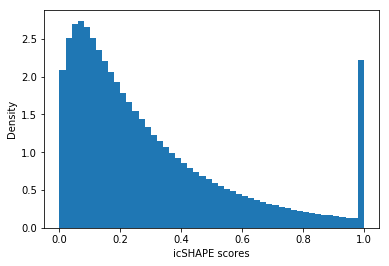

In [95]:
icshape_nonzero = icshape[np.logical_not(np.isnan(icshape))]
icshape_nonzero = icshape_nonzero[np.nonzero(icshape_nonzero)[0]]
hist(icshape_nonzero, bins=50, normed=True)
xlabel('icSHAPE scores')
ylabel('Density')

In [13]:
f = h5py.File('../data/icSHAPE/Spitale_2015_invivo/deepfold/r=CDS,p=5,w=100,dense=1', 'r')
y_train = f['y_train'][:]
y_test = f['y_test'][:]
f.close()

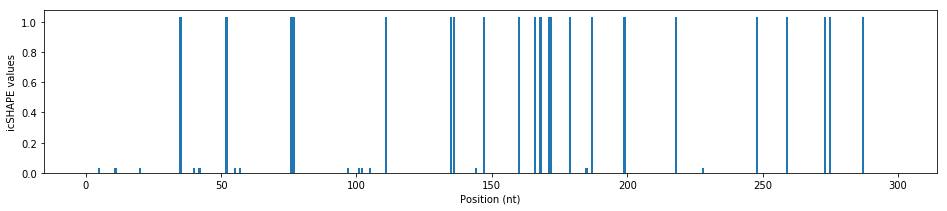

In [55]:
labels = np.copy(np.ravel(y_train)[200:500])
labels += 0.03
labels[np.isnan(labels)] = 0
subplots(figsize=(16, 3))
bar(np.arange(labels.shape[0]), labels)
xlabel('Position (nt)')
ylabel('icSHAPE values')

In [61]:
print float(np.isnan(y_test).sum())/np.prod(y_test.shape)

0.904984015216


In [60]:
y_test.shape

(24711, 100)

In [15]:
f = h5py.File('../data/icSHAPE/Spitale_2015_invivo/all', 'r')
rpkm = f['/meta/rpkm'][:]
icshape_all = f['/feature/icshape'][:]
name_all = f['/name'][:]
start_all = f['/start'][:]
end_all = f['/end'][:]
length_all = f['/meta/length'][:]
f.close()

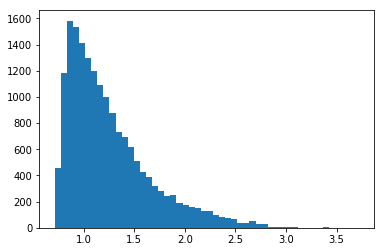

In [16]:
hist(log10(rpkm+0.1), bins=50)
pass

In [17]:
zero_ratios = np.empty(name_all.shape[0])
nan_ratios = np.empty(name_all.shape[0])
for i in range(rpkm.shape[0]):
    values = icshape_all[start_all[i]:end_all[i]]
    values_not_nan = values[np.logical_not(np.isnan(values))]
    zero_ratios[i] = float(np.sum(values_not_nan == 0))/values.shape[0]
    nan_ratios[i] = float(np.sum(np.isnan(values)))/values.shape[0]

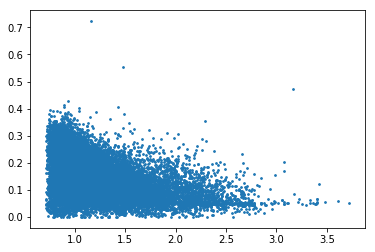

In [18]:
scatter(log10(rpkm + 0.1), zero_ratios, s=3)

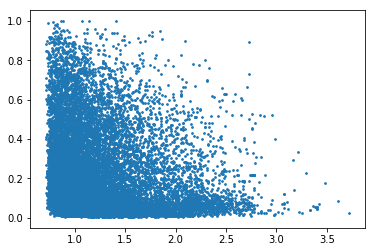

In [19]:
scatter(log10(rpkm + 0.1), nan_ratios, s=3)

In [20]:
rpkm_bypos = np.repeat(rpkm, length_all)

In [21]:
rpkm_bypos.shape

(30845716,)

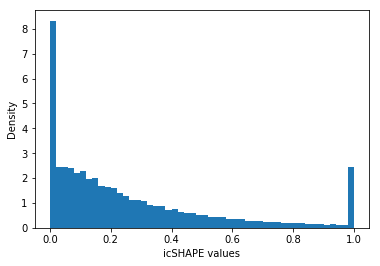

In [44]:
icshape_high_rpkm = icshape_all[rpkm_bypos > 30]
icshape_high_rpkm = icshape_high_rpkm[np.logical_not(np.isnan(icshape_high_rpkm))]
#icshape_high_rpkm = icshape_high_rpkm[icshape_high_rpkm > 0]
hist(icshape_high_rpkm, bins=50, normed=True)
xlabel('icSHAPE values')
ylabel('Density')
pass

In [23]:
def normalize(background_file, target_file):
    f = h5py.File(background_file, 'r')
    background = {}
    for key in f.keys():
        if key == 'n_seqs':
            continue
        background[key] = f[key][:]
    background['name_dict'] = {name: i for i, name in enumerate(background['name'])}
    f.close()
    f = h5py.File(target_file, 'r')
    target = {}
    for key in f.keys():
        if key == 'n_seqs':
            continue
        target[key] = f[key][:]
    f.close()
    target['name_dict'] = {name: i for i, name in enumerate(target['name'])}
    
    names_background = set(background['name'][background['rpkm'] > 30].tolist())
    names_target = set(target['name'][target['rpkm'] > 30].tolist())
    names_common = list(names_background & names_target)

    target_rt_stop = []
    background_rt_stop = []
    target_base_density = []
    background_base_density = []
    for name in names_common:
        target_ind = target['name_dict'][name]
        background_ind = background['name_dict'][name]
        target_rt_stop.append(target['rt_stop'][target['start'][target_ind]:target['end'][target_ind]])
        background_rt_stop.append(background['rt_stop'][background['start'][background_ind]:background['end'][background_ind]])
        target_base_density.append(target['base_density'][target['start'][target_ind]:target['end'][target_ind]])
        background_base_density.append(background['base_density'][background['start'][background_ind]:background['end'][background_ind]])
    target_rt_stop = np.concatenate(target_rt_stop)
    background_rt_stop = np.concatenate(background_rt_stop)
    target_base_density = np.concatenate(target_base_density)
    background_base_density = np.concatenate(background_base_density)
    return target_rt_stop, background_rt_stop, target_base_density, background_base_density
a, b, c, d = normalize('../data/icSHAPE/Spitale_2015_invitro/background.normalized',
         '../data/icSHAPE/Spitale_2015_invitro/target.normalized')

In [24]:
print a.shape, b.shape, c.shape, d.shape

(5055495,) (5055495,) (5055495,) (5055495,)


In [34]:
non_nan_mask = np.logical_not(np.any(np.vstack([np.isnan(a), np.isnan(b), np.isnan(c), np.isnan(d), c < 20, d < 20, a == 0, b == 0]), axis=0))
y = (np.log(a[non_nan_mask] + 1) - np.log(b[non_nan_mask] + 1))/(np.log(c[non_nan_mask] + 1) + np.log(d[non_nan_mask] + 1))
y = np.clip(y, -3, 3)

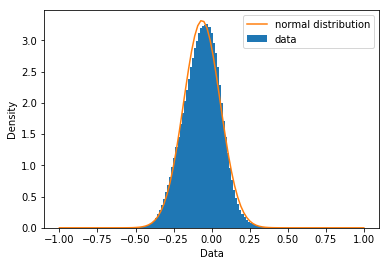

In [46]:
y_mean = np.mean(y)
y_std = np.std(y)
x = np.linspace(-1, 1, 100)
hist(np.clip(y, -3, 3), normed=True, bins=100, label='data')
plot(x, scipy.stats.norm.pdf(x, loc=y_mean, scale=y_std), label='normal distribution')
xlabel('Data')
ylabel('Density')
legend()
pass

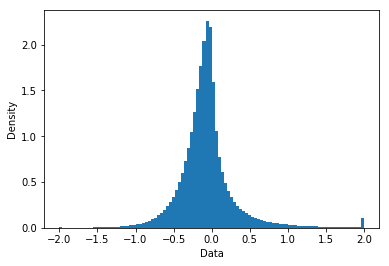

In [106]:
y_nolog = (a[non_nan_mask] - b[non_nan_mask])/(c[non_nan_mask] + d[non_nan_mask])
y_nolog = np.clip(y_nolog, -2, 2)
hist(y_nolog, normed=True, bins=100)
xlabel('Data')
ylabel('Density')
pass

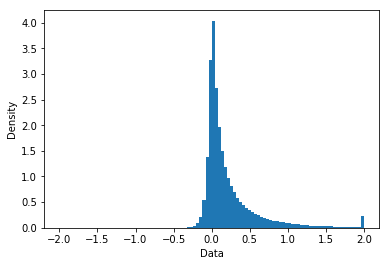

In [107]:
y_nolog = (a[non_nan_mask] - 0.25*b[non_nan_mask])/(c[non_nan_mask] + d[non_nan_mask])
y_nolog = np.clip(y_nolog, -2, 2)
hist(y_nolog, normed=True, bins=100)
xlabel('Data')
ylabel('Density')
pass

In [38]:
hist?

In [96]:
ks_result = scipy.stats.kstest(np.clip(y, -3, 3), 'norm')

In [98]:
ks_result.pvalue

0.0

In [32]:
print np.mean(np.clip(y, -3, 3)), np.std(np.clip(y, -3, 3))

-0.0634556 0.120169


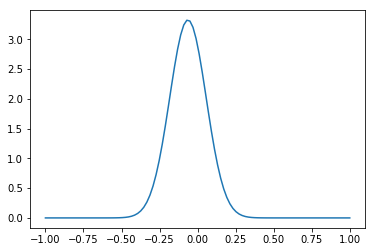

In [37]:
plot(x, scipy.stats.norm.pdf(x, loc=-0.0635, scale=0.12))

In [40]:
y_full = np.full(non_nan_mask.shape[0], np.nan)
y_full[non_nan_mask] = y

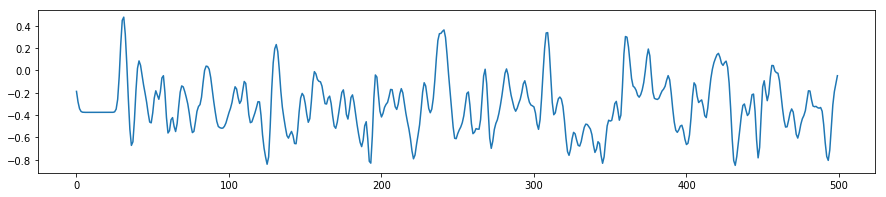

In [41]:
plot_signal_smooth(y_full[:500])

In [165]:
y_full.shape

(5055495,)

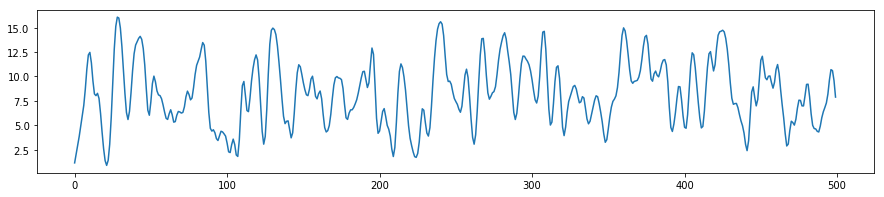

In [42]:
plot_signal_smooth(np.log(a + 1)[:500])

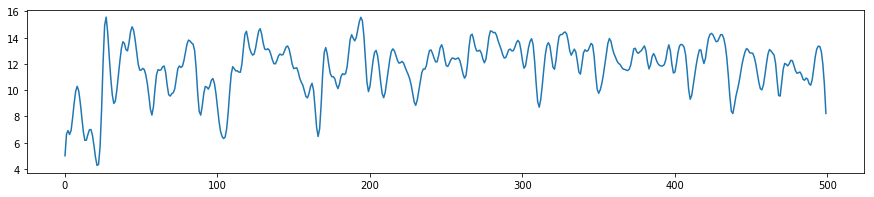

In [179]:
plot_signal_smooth(np.log(b + 1)[:500])

In [62]:
def read_ct(filename, num=0):
    """CT format specification: http://rna.urmc.rochester.edu/Text/File_Formats.html
    A CT (Connectivity Table) file contains secondary structure information for a sequence.
    These files are saved with a CT extension.
    When entering a structure to calculate the free energy, the following format must be followed.

    Start of first line: number of bases in the sequence
    End of first line: title of the structure
    Each of the following lines provides information about a given base in the sequence. Each base has its own line, with these elements in order:
    Base number: index n
    Base (A, C, G, T, U, X)
    Index n-1
    Index n+1
    Number of the base to which n is paired. No pairing is indicated by 0 (zero).
    Natural numbering. RNAstructure ignores the actual value given in natural numbering, so it is easiest to repeat n here.
    """
    records = []
    with open(filename, 'r') as f:
        line = f.readline()
        while len(line) > 0:
            fields = line.strip().split()
            length = int(fields[0])
            title = fields[-1].strip()
            seq = bytearray(length)
            pairs = [0] * length

            for j in range(length):
                fields = f.readline().strip().split()
                i = int(fields[0])
                seq[i - 1] = fields[1]
                pair = int(fields[4])
                if pair > 0:
                    pairs[i - 1] = pair
                else:
                    pairs[i - 1] = 0
            records.append((title, str(seq), pairs))
            line = f.readline()
    if num < 0:
        return records
    else:
        return records[num]

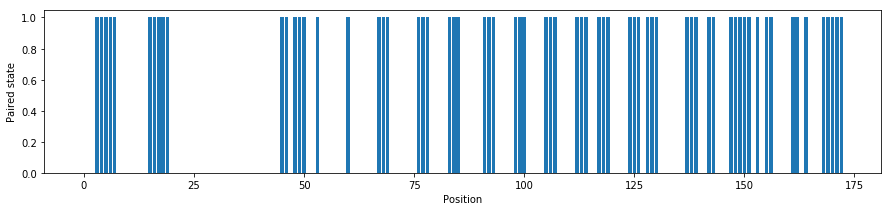

In [74]:
ct = read_ct('../data/Known/ct/16s_C.elegans_domain1.ct')
subplots(figsize=(15, 3))
bar(np.arange(len(ct[2])), (np.asarray(ct[2]) > 0).astype('int32'), edgecolor='none')
xlabel('Position')
ylabel('Paired state')